Unzipping the Dataset

In [1]:
! unzip "/content/Digital Naturalist Dataset.zip"

Archive:  /content/Digital Naturalist Dataset.zip
   creating: Digital Naturalist Dataset/
   creating: Digital Naturalist Dataset/Bird/
   creating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (1).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (10).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (11).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (2).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (3).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (4).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (5).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (6).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bir

Importing the Required Libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir
import time

Data Augmentation Function

In [3]:
def hms_string(sec_elapsed):
  h = int (sec_elapsed)/ (60*60);
  m = int ((sec_elapsed % (60*60))/60)
  s = sec_elapsed % 60
  return f"{h}:{m}:{round(s,1)}"


def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=30, 
                                  width_shift_range=0.1,
                                  height_shift_range=0.15, 
                                  shear_range=0.25, 
                                  zoom_range = 0.2,
                                  horizontal_flip=True, 
                                  vertical_flip=False, 
                                  fill_mode='nearest',
                                  brightness_range=(0.5,1.2)
                                 )
    print(data_gen)
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]    
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

Calling the augment_data function for all the sub folders

In [4]:
start_time = time.time()

augmented_data_path = '/content/Augument Dataset'
augment_data(file_dir='/content/Digital Naturalist Dataset/Bird/Great Indian Bustard Bird', n_generated_samples=10, save_to_dir=augmented_data_path+'/Bird/GIB_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Bird/Spoon Billed Sandpiper Bird', n_generated_samples=10, save_to_dir=augmented_data_path+'/Bird/SPS_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Flower/Corpse Flower', n_generated_samples=10, save_to_dir=augmented_data_path+'/Flower/Corpse_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Flower/Lady Slipper Orchid Flower', n_generated_samples=10, save_to_dir=augmented_data_path+'/Flower/LS_Orchid_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Mammal/Pangolin Mammal', n_generated_samples=10, save_to_dir=augmented_data_path+'/Mammal/LS_Pangolin_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Mammal/Senenca White Deer Mammal', n_generated_samples=10, save_to_dir=augmented_data_path+'/Mammal/SW_Deer_AUG')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Elapsed time: 0.0075:0:27.9


Importing the Required Libraries



In [5]:
import numpy as np

import tensorflow as tf
import keras
import keras.backend as K

from keras.optimizers import SGD, Adam, Adagrad, RMSprop
from keras.applications import *
from keras.preprocessing import *
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization, Dropout
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import glob
from PIL import Image
import os
from os import listdir

Make A List Of Paths To All Folders Where Data is Present


---



In [6]:
def getListOfFiles(dirName):
  listOfFile = os.listdir(dirName)
  allFiles = list()
  for fol_name in listOfFile:
    fullPath = os.path.join(dirName, fol_name)
    allFiles.append(fullPath) 
  return allFiles

dirName = '/content/Augument Dataset'
Folders = getListOfFiles(dirName)

subfolders = []
for num in range(len(Folders)):
  sub_fols = getListOfFiles(Folders[num])
  subfolders += sub_fols

print(subfolders)

['/content/Augument Dataset/Mammal/.ipynb_checkpoints', '/content/Augument Dataset/Mammal/LS_Pangolin_AUG', '/content/Augument Dataset/Mammal/SW_Deer_AUG', '/content/Augument Dataset/Bird/GIB_AUG', '/content/Augument Dataset/Bird/.ipynb_checkpoints', '/content/Augument Dataset/Bird/SPS_AUG', '/content/Augument Dataset/Flower/Corpse_AUG', '/content/Augument Dataset/Flower/.ipynb_checkpoints', '/content/Augument Dataset/Flower/LS_Orchid_AUG']


Loading Images Into Machine Understandable Data.


In [7]:
X_data = []
Y_data = []
id_no = 0

found = []

for paths in subfolders:

  files = glob.glob (paths + "/*.jpg")

  found.append((paths.split('/')[-2],paths.split('/')[-1]))

  for myFile in files:
    img = Image.open(myFile)

    img = img.resize((224,224), Image.ANTIALIAS)

    img = np.array(img)

    if img.shape == ((224, 224, 3)):

      X_data.append (img)
      Y_data.append (id_no)
  id_no+=1


Data Splitting Into Train And Test

In [8]:
print(X_data)
print(Y_data)

X = np.array(X_data)
Y = np.array(Y_data)

print("x-shape",X.shape,"y shape",Y.shape)

X = X.astype('float32')/255.0

y_cat = to_categorical(Y_data, len(subfolders))

print("X shape", X, "y_cat shape", y_cat)
print("X shape", X.shape, "y_cat shape", y_cat.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.2)

print("The model has  "+ str(len(X_train))+" inputs")


Streaming output truncated to the last 5000 lines.
        [111, 132,  75]],

       ...,

       [[ 80,  96,  70],
        [ 77,  93,  66],
        [ 74,  90,  61],
        ...,
        [ 47,  60,  21],
        [ 52,  65,  27],
        [ 56,  69,  28]],

       [[ 85, 100,  78],
        [ 82,  99,  72],
        [ 79,  95,  67],
        ...,
        [ 50,  65,  23],
        [ 53,  69,  27],
        [ 56,  71,  28]],

       [[ 89, 104,  83],
        [ 87, 102,  78],
        [ 83,  99,  73],
        ...,
        [ 53,  68,  25],
        [ 55,  70,  27],
        [ 56,  71,  28]]], dtype=uint8), array([[[113,  85,  37],
        [113,  86,  38],
        [114,  86,  38],
        ...,
        [123, 172,  65],
        [121, 170,  61],
        [120, 169,  60]],

       [[106,  85,  34],
        [106,  85,  33],
        [107,  86,  35],
        ...,
        [123, 172,  63],
        [122, 171,  62],
        [121, 170,  61]],

       [[ 98,  84,  29],
        [ 98,  84,  29],
        [ 99,  85,  

Model Building

In [9]:
early_stop_loss = EarlyStopping(monitor = 'loss', patience = 3, verbose = 1)
early_stop_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 3, verbose = 1)
model_callbacks = [early_stop_loss, early_stop_val_acc]

Defining the model, all the layers and configurations

In [10]:
def load_CNN(output_size):
  K.clear_session()
  model = Sequential()
  model.add(Dropout(0.4, input_shape = (224, 224, 3)))

  model.add(Conv2D(256, (5, 5), input_shape = (224, 224, 3), activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2, 2)))

  model.add(Conv2D(128, (3, 3), activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2, 2)))

  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.3))

  model.add(Dense(output_size, activation = 'softmax'))

  return model


Building the model using the above defined function (load_CNN)

In [11]:
model = load_CNN(9)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
model.summary()
weights = model.get_weights()
print(weights)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        7

Loading the Train and Test Data

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

trainData = datagen.flow(X_train, y_train)

testData = datagen.flow(X_test, y_test)

Fitting the model on different batch size

In [13]:

model.set_weights(weights)

h = model.fit(trainData,
              batch_size = 16,
              epochs = 30,
              verbose = 1,
              callbacks = model_callbacks,
              shuffle = True,
              validation_data = testData)

model.summary()

Epoch 1/30
39/39 [==============================] - 902s 23s/step - loss: 2.1406 - accuracy: 0.1686 - val_loss: 1.9017 - val_accuracy: 0.1536
Epoch 2/30
39/39 [==============================] - 906s 23s/step - loss: 1.8862 - accuracy: 0.1751 - val_loss: 1.9602 - val_accuracy: 0.2810
Epoch 3/30
39/39 [==============================] - 893s 23s/step - loss: 1.5556 - accuracy: 0.3502 - val_loss: 1.2936 - val_accuracy: 0.4967
Epoch 4/30
39/39 [==============================] - 886s 23s/step - loss: 1.2632 - accuracy: 0.4820 - val_loss: 1.3711 - val_accuracy: 0.4248
Epoch 5/30
39/39 [==============================] - 909s 23s/step - loss: 1.0757 - accuracy: 0.5532 - val_loss: 1.0684 - val_accuracy: 0.6078
Epoch 6/30
39/39 [==============================] - 903s 23s/step - loss: 0.9437 - accuracy: 0.6113 - val_loss: 0.9699 - val_accuracy: 0.6601
Epoch 7/30
39/39 [==============================] - 883s 23s/step - loss: 0.7379 - accuracy: 0.7201 - val_loss: 1.0178 - val_accuracy: 0.6275
Epoch 

Evaluation (Accuracy And Losses)


In [18]:
histories_acc = []
histories_val_acc = []
histories_loss = []
histories_val_loss = []

print(h.history.keys())

histories_acc.append(h.history['accuracy'])
histories_val_acc.append(h.history['val_accuracy'])
histories_loss.append(h.history['loss'])
histories_val_loss.append(h.history['val_loss'])


histories_acc = np.array(histories_acc)
histories_val_acc = np.array(histories_val_acc)
histories_loss = np.array(histories_loss)
histories_val_loss = np.array(histories_val_loss)

print('hisotires_acc', histories_acc,
'histories_loss', histories_loss,
'histories_val_acc', histories_val_acc,
'histories_val_loss', histories_val_loss)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
hisotires_acc [[0.16857611 0.17512275 0.35024551 0.48199672 0.55319148 0.61129296
  0.72013092 0.75204581 0.82733226 0.88543373 0.89689034 0.93862522
  0.96235681 0.9672668  0.97708672]] histories_loss [[2.1405859  1.88618076 1.55560637 1.26319194 1.07573819 0.94366246
  0.73787308 0.67144513 0.45298621 0.33423832 0.27952862 0.15907776
  0.13555066 0.09837601 0.07169136]] histories_val_acc [[0.15359478 0.28104576 0.49673203 0.42483661 0.60784316 0.66013074
  0.627451   0.64705884 0.66339868 0.63398695 0.67973858 0.74509805
  0.71895427 0.72875816 0.71241832]] histories_val_loss [[1.9017185  1.96021521 1.29361331 1.3711493  1.06835747 0.96988285
  1.01776302 1.08447647 1.1559993  1.25021648 1.16665494 1.03851902
  1.10541487 1.1228013  1.43401706]]


Loading the Test Data

187


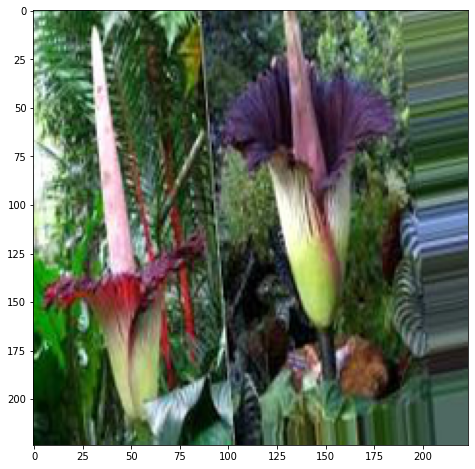

In [31]:
image_number = np.random.randint(0,len(X_test))
print(image_number)


plt.figure(figsize = (8,8))
plt.imshow(X_test[image_number])

Making a Test Prediction



In [32]:
predictions = model.predict([X_test[image_number].reshape(1,224,224,3)])


for idx, result, x in zip(range(0,6), found,predictions[0]):
	print("Label : {}, Type : {}, Species : {}, Score : {}%". format(idx, result[0], result[1], round(x*100,3)))

classIndex = np.argmax(predictions, axis = 1)

print(classIndex)

print(found[classIndex[0]])


1/1 [==============================] - 1s 546ms/step
Label : 0, Type : Mammal, Species : .ipynb_checkpoints, Score : 0.0%
Label : 1, Type : Mammal, Species : LS_Pangolin_AUG, Score : 0.0%
Label : 2, Type : Mammal, Species : SW_Deer_AUG, Score : 0.0%
Label : 3, Type : Bird, Species : GIB_AUG, Score : 0.0%
Label : 4, Type : Bird, Species : .ipynb_checkpoints, Score : 0.0%
Label : 5, Type : Bird, Species : SPS_AUG, Score : 0.0%
[6]
('Flower', 'Corpse_AUG')


Model Saving And Loading

In [34]:
model_json = model.to_json()
with open("final_model.json", "w") as json_file:
	json_file.write(model_json)


model.save_weights("final_model.h5")
print("Saved model to disk")

Saved model to disk
